# Libraries

In [12]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

Loading and displaying data info...
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Inte

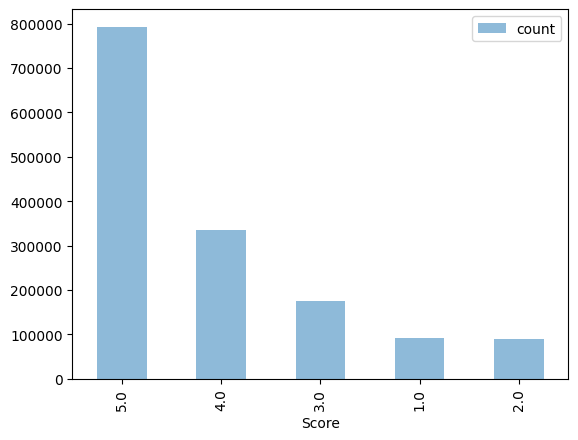


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [13]:
print("Loading and displaying data info...")
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()
print(trainingSet.describe())

# Plot score distribution
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [42]:
def add_features_to(df, training_data=None):
    # Basic helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Time-based features
    time_series = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = time_series.dt.year
    df['Month'] = time_series.dt.month
    
    # If this is submission data, use training data for means
    if training_data is not None:
        user_means = training_data.groupby('UserId')['Score'].mean()
        product_means = training_data.groupby('ProductId')['Score'].mean()
        global_mean = training_data['Score'].mean()
    else:
        user_means = df.groupby('UserId')['Score'].mean()
        product_means = df.groupby('ProductId')['Score'].mean()
        global_mean = df['Score'].mean()
    
    # User and Product history features
    df['UserMeanScore'] = df['UserId'].map(user_means)
    df['ProductMeanScore'] = df['ProductId'].map(product_means)
    
    # Fill missing values with global mean
    df['UserMeanScore'] = df['UserMeanScore'].fillna(global_mean)
    df['ProductMeanScore'] = df['ProductMeanScore'].fillna(global_mean)
    
    
    return df

if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Add features to submission set using training data statistics
    X_submission = add_features_to(X_submission, trainingSet)
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection
features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Helpfulness',
    'Year',
    'Month',
    'UserMeanScore',
    'ProductMeanScore'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Feature Selection

In [39]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Evaluating model performance...
Accuracy on testing set =  0.4059315552491544


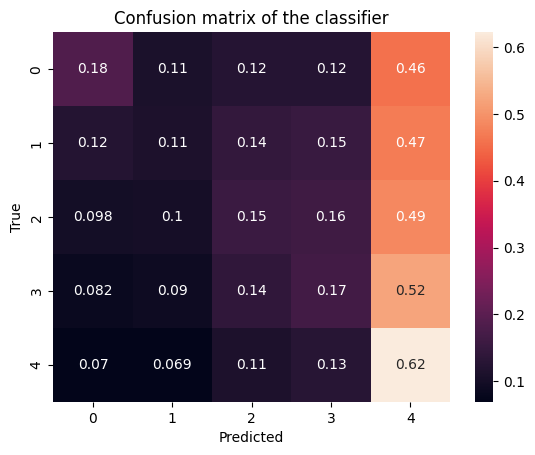

In [41]:


print("Evaluating model performance...")
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Create confusion matrix visualization
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [36]:
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
